In [6]:
import pandas as pd

In [7]:
df = pd.read_csv("energydata_with_cost.csv")

# Bekijk kolommen om te checken of price_per_kwh erin zit
print("Kolommen:", df.columns)

# Als price_per_kwh erin zit, bereken typische waarden:
if "price_per_kwh" in df.columns:
    print("Gemiddelde prijs (mean):", df["price_per_kwh"].mean())
    print("Mediaan prijs (median):", df["price_per_kwh"].median())
    print("Meest voorkomende prijs (modus):", df["price_per_kwh"].mode()[0])
else:
    print("⚠️ Kolom 'price_per_kwh' niet gevonden.")


for col in df.columns:
    print(f"'{col}'")



Kolommen: Index(['locationUid', 'actualEVSEId', 'sessionDurationMs',
       'chargingDurationMs', 'startTime', 'activeStartTime',
       'chargingStartTime', 'chargingEndTime', 'endTime',
       'chargingStartReason', 'chargingEndReason', 'endReasonDescription',
       'maxPowerKw', 'chargedEnergyKwh', 'soc', 'socStart', 'socEnd',
       'evMaximumCurrent', 'evMaximumPower', 'evMaximumVoltage', 'evIdentify',
       'evCluster', 'triggerReason', 'updateTime', 'evseName',
       'technicalFailClassification', 'idToken', 'remoteStartId',
       'estimatedCostEUR'],
      dtype='object')
⚠️ Kolom 'price_per_kwh' niet gevonden.
'locationUid'
'actualEVSEId'
'sessionDurationMs'
'chargingDurationMs'
'startTime'
'activeStartTime'
'chargingStartTime'
'chargingEndTime'
'endTime'
'chargingStartReason'
'chargingEndReason'
'endReasonDescription'
'maxPowerKw'
'chargedEnergyKwh'
'soc'
'socStart'
'socEnd'
'evMaximumCurrent'
'evMaximumPower'
'evMaximumVoltage'
'evIdentify'
'evCluster'
'triggerReason'
'u

In [8]:
df = df[df['chargedEnergyKwh'].astype(float) > 0]
df["price_per_kwh"] = df["estimatedCostEUR"].astype(float) / df['chargedEnergyKwh'].astype(float)

print("Gemiddelde prijs per kWh:", df["price_per_kwh"].mean())
print("Mediaan prijs per kWh:", df["price_per_kwh"].median())


Gemiddelde prijs per kWh: 0.0891165075413662
Mediaan prijs per kWh: 0.09816


In [9]:
import pandas as pd

# Stap 1: Data inladen
df = pd.read_csv("energydata_with_cost.csv")  # pas pad aan indien nodig

# Stap 2: Zorg dat getallen correct geïnterpreteerd worden
df['chargedEnergyKwh'] = pd.to_numeric(df['chargedEnergyKwh'], errors="coerce")
df["estimatedCostEUR"] = pd.to_numeric(df["estimatedCostEUR"], errors="coerce")

# Stap 3: Verwijder rijen met foutieve of lege waardes
df = df[(df['chargedEnergyKwh'] > 0) & (df["estimatedCostEUR"] >= 0)]

# Stap 4: Bereken prijs per kWh
df["price_per_kwh"] = df["estimatedCostEUR"] / df['chargedEnergyKwh']

# Stap 5: Print resultaten
print("Gemiddelde energieverbruik (kWh):", df['chargedEnergyKwh'].mean())
print("Mediaan energieverbruik (kWh):", df['chargedEnergyKwh'].median())

print("Gemiddelde kostprijs (€):", df["estimatedCostEUR"].mean())
print("Mediaan kostprijs (€):", df["estimatedCostEUR"].median())

print("Gemiddelde prijs per kWh (€):", df["price_per_kwh"].mean())
print("Mediaan prijs per kWh (€):", df["price_per_kwh"].median())


Gemiddelde energieverbruik (kWh): 108.30084961552465
Mediaan energieverbruik (kWh): 96.031
Gemiddelde kostprijs (€): 11.049095210668543
Mediaan kostprijs (€): 8.356046351479128
Gemiddelde prijs per kWh (€): 0.1007025601683033
Mediaan prijs per kWh (€): 0.10212283821131708


In [10]:
!pip install keras-tuner --quiet

Trial 2 Complete [00h 00m 21s]
val_loss: 299972.96875

Best val_loss So Far: 299972.96875
Total elapsed time: 00h 01m 25s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test MAE  : 417.42 kWh
Test RMSE : 595.78 kWh
Test R²   : 0.857


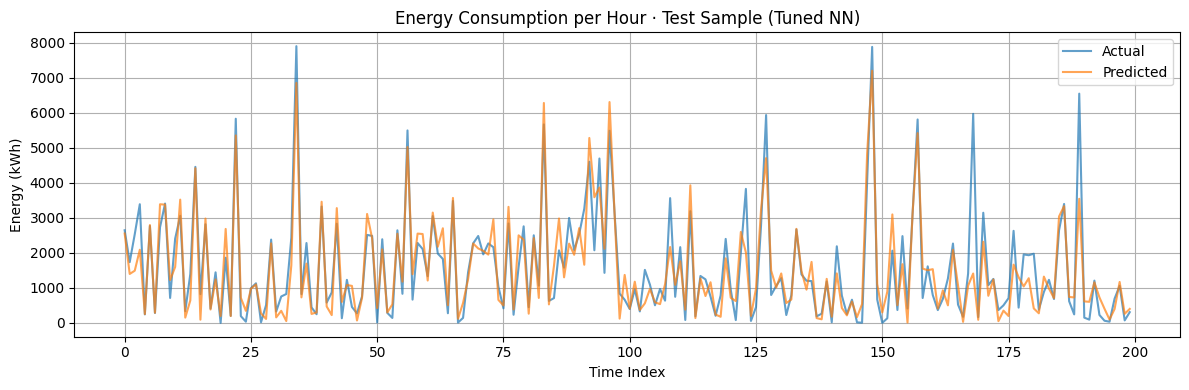

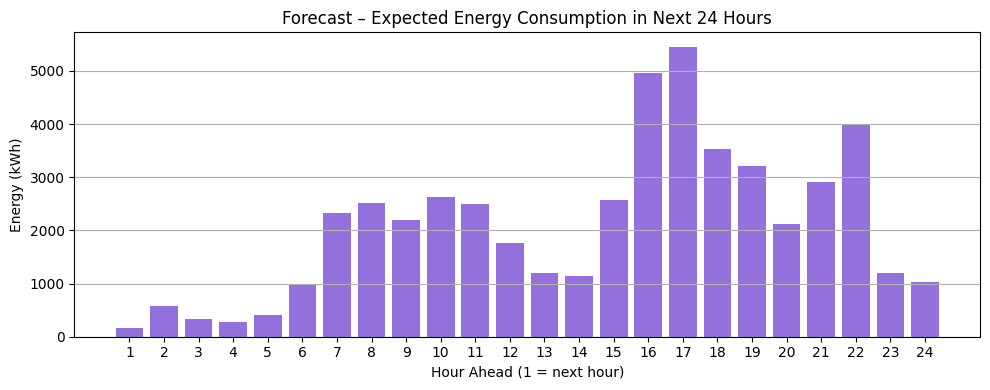

✅ CSV saved as predicted_energy_consumption.csv


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import keras_tuner as kt  # <- dit is voor je 'kt.RandomSearch'


# 1. Load & preprocess
df = pd.read_csv("energydata_with_cost.csv", parse_dates=["chargingStartTime"])
df = df[df["chargedEnergyKwh"] > 0].copy()

df["hour_of_day"] = df["chargingStartTime"].dt.floor("H")
hourly = (
    df.groupby("hour_of_day")["chargedEnergyKwh"]
      .sum()
      .rename("energy_kwh")
      .reset_index()
)

# 2. Time-features
hourly["hour"]       = hourly["hour_of_day"].dt.hour
hourly["weekday"]    = hourly["hour_of_day"].dt.weekday
hourly["is_weekend"] = (hourly["weekday"] >= 5).astype(int)

# 3. Supervised dataset (24 lags)
WINDOW = 24
rows = []
for i in range(WINDOW, len(hourly)):
    lags       = hourly["energy_kwh"].values[i-WINDOW:i]
    time_feats = hourly.loc[i, ["hour", "weekday", "is_weekend"]].values
    target     = hourly.loc[i, "energy_kwh"]
    rows.append(np.hstack([lags, time_feats, target]))

cols = [f"lag_{j}" for j in range(WINDOW, 0, -1)] + ["hour", "weekday", "is_weekend", "target"]
sup_df = pd.DataFrame(rows, columns=cols)

# 4. Train/test split
X = sup_df.drop("target", axis=1).values.astype("float32")
y = sup_df["target"].values.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# 5. Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 6. Hyperparameter tuning with Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int("units_1", 32, 256, step=32),
        activation=hp.Choice("activation_1", ["relu", "tanh"]),
        input_shape=(X_train_s.shape[1],)
    ))
    for i in range(hp.Int("n_layers", 1, 3)):
        model.add(Dense(
            units=hp.Int(f"units_{i+2}", 16, 128, step=16),
            activation=hp.Choice(f"activation_{i+2}", ["relu", "tanh"])
        ))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="mse"
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory="tuner_energy",
    project_name="forecast_energy"
)

tuner.search(X_train_s, y_train,
             validation_split=0.1,
             epochs=100,
             batch_size=32,
             callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

# 7. Evaluate
y_pred = best_model.predict(X_test_s).flatten()
print(f"Test MAE  : {mean_absolute_error(y_test, y_pred):.2f} kWh")
print(f"Test RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} kWh")
print(f"Test R²   : {r2_score(y_test, y_pred):.3f}")

plt.figure(figsize=(12,4))
plt.plot(y_test[:200], label="Actual", alpha=0.7)
plt.plot(y_pred[:200], label="Predicted", alpha=0.7)
plt.title("Energy Consumption per Hour · Test Sample (Tuned NN)")
plt.xlabel("Time Index")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Forecast next 24 hours
last_window = hourly["energy_kwh"].values[-WINDOW:].tolist()
forecast = []
for step in range(1, 25):
    next_hour_dt = hourly["hour_of_day"].iloc[-1] + pd.Timedelta(hours=step)
    h, wd = next_hour_dt.hour, next_hour_dt.weekday()
    is_we = int(wd >= 5)
    features = np.hstack([last_window[-WINDOW:], [h, wd, is_we]])
    pred = best_model.predict(scaler.transform(features.reshape(1, -1)), verbose=0)[0,0]
    forecast.append((step, pred))
    last_window.append(pred)

forecast_df = pd.DataFrame(forecast, columns=["hour_ahead", "predicted_energy_kwh"])

# 9. Plot forecast
plt.figure(figsize=(10,4))
plt.bar(forecast_df["hour_ahead"], forecast_df["predicted_energy_kwh"],
        color="mediumpurple")
plt.title("Forecast – Expected Energy Consumption in Next 24 Hours")
plt.xlabel("Hour Ahead (1 = next hour)")
plt.ylabel("Energy (kWh)")
plt.xticks(range(1, 25))
plt.grid(axis="y")
plt.tight_layout()
plt.show()

forecast_df.to_csv("predicted_energy_consumption.csv", index=False)
print("✅ CSV saved as predicted_energy_consumption.csv")

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict opnieuw (indien nodig)
y_pred = best_model.predict(X_test_s).flatten()

# DataFrame met fouten
df_errors = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})
df_errors['abs_error'] = np.abs(df_errors['actual'] - df_errors['predicted'])

# Verwijder outliers: bovenste 1% absolute error
threshold = df_errors['abs_error'].quantile(0.99)
df_filtered = df_errors[df_errors['abs_error'] < threshold]

# Herbereken metrics
mae  = mean_absolute_error(df_filtered['actual'], df_filtered['predicted'])
rmse = np.sqrt(mean_squared_error(df_filtered['actual'], df_filtered['predicted']))
r2   = r2_score(df_filtered['actual'], df_filtered['predicted'])

print(f"MAE zonder outliers : {mae:.2f} kWh")
print(f"RMSE zonder outliers: {rmse:.2f} kWh")
print(f"R² zonder outliers  : {r2:.3f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE zonder outliers : 394.68 kWh
RMSE zonder outliers: 529.82 kWh
R² zonder outliers  : 0.884


In [13]:
print(f"Gemiddeld werkelijk energieverbruik (y_test): {np.mean(np.expm1(y_test)):.2f} kWh")
print(f"Gemiddelde voorspelling: {np.mean(y_pred):.2f} kWh")


Gemiddeld werkelijk energieverbruik (y_test): inf kWh
Gemiddelde voorspelling: 1559.86 kWh


/tmp/ipython-input-13-2566121859.py:1: RuntimeWarning: overflow encountered in expm1
  print(f"Gemiddeld werkelijk energieverbruik (y_test): {np.mean(np.expm1(y_test)):.2f} kWh")


In [14]:
y_raw = sup_df["target"].values.astype("float32")
y = np.log1p(y_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# 👉 y_test moet gelogd zijn. Controleer even:
print(f"Max y_test: {np.max(y_test)}")        # zou rond ~10 moeten zijn
print(f"Max expm1(y_test): {np.max(np.expm1(y_test))}")  # zou normale kWh moeten zijn


Max y_test: 8.98531723022461
Max expm1(y_test): 7983.9775390625


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import keras_tuner as kt

# Load & clean
df = pd.read_csv("energydata_with_cost.csv")
df["chargingStartTime"] = pd.to_datetime(df["chargingStartTime"], errors="coerce")
df = df.dropna(subset=["chargingStartTime"])
df = df[df["chargedEnergyKwh"] > 0].copy()

# Aggregate sessions per hour
df.set_index("chargingStartTime", inplace=True)
hourly_counts = df.resample("H").size().rename("sessions")
hourly_counts = hourly_counts.asfreq("H", fill_value=0)

# Create supervised features
WINDOW = 24
X, y = [], []
vals = hourly_counts.values
for i in range(len(vals) - WINDOW):
    X.append(vals[i:i + WINDOW])
    y.append(vals[i + WINDOW])
X = np.array(X)
y = np.array(y)

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


/tmp/ipython-input-18-1625380221.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_counts = df.resample("H").size().rename("sessions")
/tmp/ipython-input-18-1625380221.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_counts = hourly_counts.asfreq("H", fill_value=0)


In [19]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units1', 32, 256, step=32),
        activation=hp.Choice('act1', ['relu', 'tanh']),
        input_shape=(X_train.shape[1],)
    ))
    if hp.Boolean('dropout1'):
        model.add(Dropout(rate=hp.Float('dropout_rate1', 0.1, 0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('units2', 16, 128, step=16),
        activation=hp.Choice('act2', ['relu', 'tanh'])
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss="mse",
        metrics=["mae"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=3,
    overwrite=True,
    directory='tuning_dir',
    project_name='charging_forecast'
)

tuner.search(X_train, y_train, validation_split=0.2, epochs=50, verbose=1)


Trial 3 Complete [00h 00m 35s]
val_mae: 4.455353260040283

Best val_mae So Far: 4.217824935913086
Total elapsed time: 00h 01m 39s


In [20]:
# Voorspel
best_model = tuner.get_best_models(1)[0]
y_pred = best_model.predict(X_test).flatten()

# MET outliers
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 MET outliers:")
print(f"MAE  : {mae:.2f} sessions")
print(f"RMSE : {rmse:.2f} sessions")
print(f"R²   : {r2:.3f}")

# ZONDER outliers (minder dan 3 std afwijken)
errors = np.abs(y_test - y_pred)
threshold = errors.mean() + 3 * errors.std()
mask = errors < threshold

mae_clean = mean_absolute_error(y_test[mask], y_pred[mask])
rmse_clean = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
r2_clean = r2_score(y_test[mask], y_pred[mask])

print("\n📊 ZONDER outliers:")
print(f"MAE  : {mae_clean:.2f} sessions")
print(f"RMSE : {rmse_clean:.2f} sessions")
print(f"R²   : {r2_clean:.3f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
📊 MET outliers:
MAE  : 4.15 sessions
RMSE : 5.54 sessions
R²   : 0.807

📊 ZONDER outliers:
MAE  : 3.91 sessions
RMSE : 5.02 sessions
R²   : 0.838


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

# --- 1. Load original data (keep full copy for later outlier comparison) ---
df_all = pd.read_csv("energydata_with_cost.csv")
df_all = df_all[(df_all.chargedEnergyKwh > 0) & (df_all.estimatedCostEUR > 0)].copy()
df_all["price_per_kwh"] = df_all.estimatedCostEUR / df_all.chargedEnergyKwh

# Store unfiltered copy for evaluation later
df_filtered = df_all.copy()

# --- 2. Outlier filtering ---
q_low = df_filtered["price_per_kwh"].quantile(0.01)
q_high = df_filtered["price_per_kwh"].quantile(0.99)
df_filtered = df_filtered[(df_filtered["price_per_kwh"] >= q_low) & (df_filtered["price_per_kwh"] <= q_high)]

# --- 3. Feature engineering ---
def prepare_features(df):
    df["chargingStartTime"] = pd.to_datetime(df["chargingStartTime"], errors="coerce")
    df = df.dropna(subset=["chargingStartTime"])
    df["hour"] = df.chargingStartTime.dt.hour
    df["weekday"] = df.chargingStartTime.dt.weekday
    df["month"] = df.chargingStartTime.dt.month
    df["chargedEnergyKwh_log"] = np.log1p(df["chargedEnergyKwh"])
    df["hour_sin"] = np.sin(2 * np.pi * df.hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df.hour / 24)
    df["weekday_sin"] = np.sin(2 * np.pi * df.weekday / 7)
    df["weekday_cos"] = np.cos(2 * np.pi * df.weekday / 7)
    month_dummies = pd.get_dummies(df.month, prefix="month", drop_first=True)
    df = pd.concat([df, month_dummies], axis=1)
    return df

df_filtered = prepare_features(df_filtered)
df_all = prepare_features(df_all)  # For evaluation with outliers

feature_cols = [
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "chargedEnergyKwh_log"
] + [col for col in df_filtered.columns if col.startswith("month_")]

X = df_filtered[feature_cols].values
y = df_filtered["price_per_kwh"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# --- 4. Model definition for tuner ---
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_s.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", 32, 256, step=32),
            activation=hp.Choice("activation", ["relu", "tanh", "elu"])
        ))
        model.add(tf.keras.layers.Dropout(
            rate=hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)
        ))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="mse"
    )
    return model

# --- 5. Tuning ---
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=2,
    overwrite=True,
    directory="tuner_dir",
    project_name="price_prediction"
)
tuner.search(X_train_s, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
best_model = tuner.get_best_models(num_models=1)[0]

# --- 6. Evaluate with and without outliers ---
print("📊 Evaluation WITH outliers:")
X_all = df_all[feature_cols].values
y_all = df_all["price_per_kwh"].values
X_all_scaled = scaler.transform(X_all)
y_all_pred = best_model.predict(X_all_scaled).flatten()
print(f"MAE  : {mean_absolute_error(y_all, y_all_pred):.4f} €/kWh")
print(f"RMSE : {np.sqrt(mean_squared_error(y_all, y_all_pred)):.4f} €/kWh")
print(f"R²   : {r2_score(y_all, y_all_pred):.3f}")

print("\n📊 Evaluation WITHOUT outliers:")
y_pred = best_model.predict(X_test_s).flatten()
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.4f} €/kWh")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.4f} €/kWh")
print(f"R²   : {r2_score(y_test, y_pred):.3f}")


Trial 2 Complete [00h 04m 03s]
val_loss: 0.0005699920002371073

Best val_loss So Far: 0.0005699920002371073
Total elapsed time: 00h 06m 20s
📊 Evaluation WITH outliers:
   1/1456 ━━━━━━━━━━━━━━━━━━━━ 1:36 66ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1456/1456 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
MAE  : 0.0192 €/kWh
RMSE : 0.0267 €/kWh
R²   : 0.628

📊 Evaluation WITHOUT outliers:
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE  : 0.0183 €/kWh
RMSE : 0.0242 €/kWh
R²   : 0.642


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


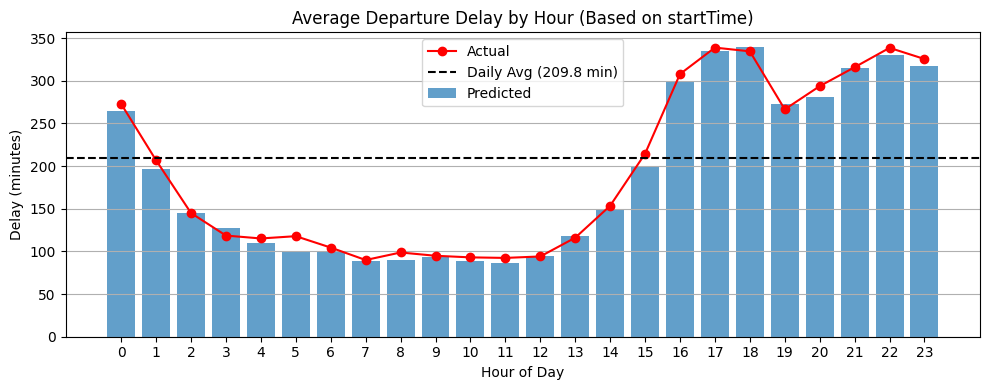

In [22]:
# Updated full script using 'startTime' instead of 'chargingStartTime'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Load & preprocess
df = pd.read_csv("energydata_with_cost.csv", parse_dates=["startTime", "chargingStartTime", "endTime"])

# Remove timezone info if present
df["startTime"] = df["startTime"].dt.tz_localize(None)
df["endTime"] = df["endTime"].dt.tz_localize(None)

df = df[df["chargedEnergyKwh"] > 0].copy()

# Compute delay from startTime to endTime
df["departure_delay_minutes"] = (df["endTime"] - df["startTime"]).dt.total_seconds() / 60

# Time features based on startTime
df["hour"] = df["startTime"].dt.hour
df["weekday"] = df["startTime"].dt.weekday
df["is_weekend"] = (df["weekday"] >= 5).astype(int)
df["dayofyear"] = df["startTime"].dt.dayofyear
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

# Energy features
df["chargedEnergyKwh_log"] = np.log1p(df["chargedEnergyKwh"])

# Shift indicators
df["shift_start_morning"] = df["hour"].between(7, 9).astype(int)
df["shift_end_evening"] = df["hour"].between(16, 18).astype(int)
df["weekend_and_shift"] = df["shift_start_morning"] * df["is_weekend"]

# Categorical bins
df["start_hour_bin"] = pd.cut(df["hour"], bins=[0, 6, 10, 16, 21, 24],
                              labels=["Night", "Morning", "Afternoon", "Evening", "Late"], right=False)

# One-hot encoding
weekday_dummies = pd.get_dummies(df["weekday"], prefix="wd", drop_first=True)
period_dummies = pd.get_dummies(df["start_hour_bin"], prefix="period", drop_first=True)
df = pd.concat([df, weekday_dummies, period_dummies], axis=1)

# 2. Feature set
feature_cols = [
    "hour_sin", "hour_cos", "is_weekend", "chargedEnergyKwh_log", "chargedEnergyKwh",
    "shift_start_morning", "shift_end_evening", "weekend_and_shift",
    "dayofyear_sin", "dayofyear_cos"
] + list(weekday_dummies.columns) + list(period_dummies.columns)

X = df[feature_cols].values.astype("float32")
y = df["departure_delay_minutes"].values.astype("float32")

# 3. Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

model.fit(
    X_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=0
)

# 4. Evaluate
y_pred = model.predict(X_test_s).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Save predictions
df["predicted_departure_delay_minutes"] = model.predict(scaler.transform(X)).flatten()

# 5. Hourly summary
hourly = (
    df.groupby("hour")[["departure_delay_minutes", "predicted_departure_delay_minutes"]]
    .mean()
    .reset_index()
)
daily_avg = df["departure_delay_minutes"].mean()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(hourly["hour"], hourly["predicted_departure_delay_minutes"], label="Predicted", alpha=0.7)
plt.plot(hourly["hour"], hourly["departure_delay_minutes"], color="red", marker="o", label="Actual")
plt.axhline(daily_avg, color="black", linestyle="--", label=f"Daily Avg ({daily_avg:.1f} min)")
plt.title("Average Departure Delay by Hour (Based on startTime)")
plt.xlabel("Hour of Day")
plt.ylabel("Delay (minutes)")
plt.xticks(range(24))
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

daily_avg, mae, rmse, r2

# Save to CSV
hourly.to_csv("hourly_departure_prediction.csv", index=False)

In [26]:
# Predict per rij
df["predicted_delay"] = model.predict(scaler.transform(X)).flatten()

# Bereken gemiddelde voorspelling per uur (24 punten)
avg_pred_hour = df.groupby("hour")["predicted_delay"].mean()

# Koppel deze gemiddelde voorspelling terug aan alle rijen
df["predicted_hourly_avg_delay"] = df["hour"].map(avg_pred_hour)

# Evalueer die voorspelling per rij (dus alle rijen krijgen het uurgemiddelde van hun uur)
mae_mid = mean_absolute_error(df["departure_delay_minutes"], df["predicted_hourly_avg_delay"])
rmse_mid = np.sqrt(mean_squared_error(df["departure_delay_minutes"], df["predicted_hourly_avg_delay"]))
r2_mid = r2_score(df["departure_delay_minutes"], df["predicted_hourly_avg_delay"])

print("📉 Evaluation with hourly average prediction (per-row) — WITH outliers:")
print(f"MAE  : {mae_mid:.2f} minutes")
print(f"RMSE : {rmse_mid:.2f} minutes")
print(f"R²   : {r2_mid:.3f}")


# Filter op 1e tot 99e percentiel (optioneel ook 5%-95%)
low, high = df["departure_delay_minutes"].quantile([0.01, 0.99])
df_wo = df[(df["departure_delay_minutes"] >= low) & (df["departure_delay_minutes"] <= high)].copy()

# Herbereken uurgemiddelde van de voorspelling op gefilterde data
avg_pred_hour_wo = df_wo.groupby("hour")["predicted_delay"].mean()
df_wo["predicted_hourly_avg_delay"] = df_wo["hour"].map(avg_pred_hour_wo)

# Evaluatie op rijniveau (zonder extreme vertragingen)
mae_mid_wo = mean_absolute_error(df_wo["departure_delay_minutes"], df_wo["predicted_hourly_avg_delay"])
rmse_mid_wo = np.sqrt(mean_squared_error(df_wo["departure_delay_minutes"], df_wo["predicted_hourly_avg_delay"]))
r2_mid_wo = r2_score(df_wo["departure_delay_minutes"], df_wo["predicted_hourly_avg_delay"])

print("\n📉 Evaluation with hourly average prediction (per-row) — WITHOUT outliers (1st–99th percentile):")
print(f"MAE  : {mae_mid_wo:.2f} minutes")
print(f"RMSE : {rmse_mid_wo:.2f} minutes")
print(f"R²   : {r2_mid_wo:.3f}")





1618/1618 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
📉 Evaluation with hourly average prediction (per-row) — WITH outliers:
MAE  : 155.47 minutes
RMSE : 268.78 minutes
R²   : 0.134

📉 Evaluation with hourly average prediction (per-row) — WITHOUT outliers (1st–99th percentile):
MAE  : 140.07 minutes
RMSE : 195.76 minutes
R²   : 0.201


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


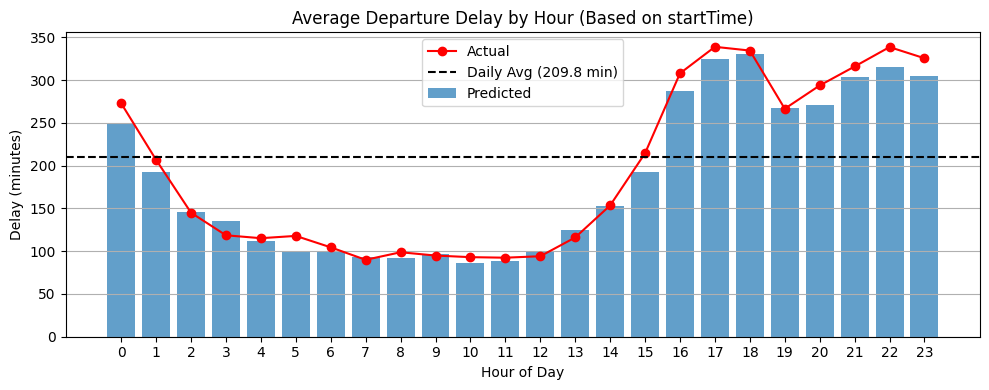

In [27]:
# Updated full script using 'startTime' instead of 'chargingStartTime'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Load & preprocess
df = pd.read_csv("energydata_with_cost.csv", parse_dates=["startTime", "chargingStartTime", "endTime"])

# Remove timezone info if present
df["startTime"] = df["startTime"].dt.tz_localize(None)
df["endTime"] = df["endTime"].dt.tz_localize(None)

df = df[df["chargedEnergyKwh"] > 0].copy()

# Compute delay from startTime to endTime
df["departure_delay_minutes"] = (df["endTime"] - df["startTime"]).dt.total_seconds() / 60

# Time features based on startTime
df["hour"] = df["startTime"].dt.hour
df["weekday"] = df["startTime"].dt.weekday
df["is_weekend"] = (df["weekday"] >= 5).astype(int)
df["dayofyear"] = df["startTime"].dt.dayofyear
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

# Energy features
df["chargedEnergyKwh_log"] = np.log1p(df["chargedEnergyKwh"])

# Shift indicators
df["shift_start_morning"] = df["hour"].between(7, 9).astype(int)
df["shift_end_evening"] = df["hour"].between(16, 18).astype(int)
df["weekend_and_shift"] = df["shift_start_morning"] * df["is_weekend"]

# Categorical bins
df["start_hour_bin"] = pd.cut(df["hour"], bins=[0, 6, 10, 16, 21, 24],
                              labels=["Night", "Morning", "Afternoon", "Evening", "Late"], right=False)

# One-hot encoding
weekday_dummies = pd.get_dummies(df["weekday"], prefix="wd", drop_first=True)
period_dummies = pd.get_dummies(df["start_hour_bin"], prefix="period", drop_first=True)
df = pd.concat([df, weekday_dummies, period_dummies], axis=1)

# 2. Feature set
feature_cols = [
    "hour_sin", "hour_cos", "is_weekend", "chargedEnergyKwh_log", "chargedEnergyKwh",
    "shift_start_morning", "shift_end_evening", "weekend_and_shift",
    "dayofyear_sin", "dayofyear_cos"
] + list(weekday_dummies.columns) + list(period_dummies.columns)

X = df[feature_cols].values.astype("float32")
y = df["departure_delay_minutes"].values.astype("float32")

# 3. Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

model.fit(
    X_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=0
)

# 4. Evaluate
y_pred = model.predict(X_test_s).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Save predictions
df["predicted_departure_delay_minutes"] = model.predict(scaler.transform(X)).flatten()

# 5. Hourly summary
hourly = (
    df.groupby("hour")[["departure_delay_minutes", "predicted_departure_delay_minutes"]]
    .mean()
    .reset_index()
)
daily_avg = df["departure_delay_minutes"].mean()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(hourly["hour"], hourly["predicted_departure_delay_minutes"], label="Predicted", alpha=0.7)
plt.plot(hourly["hour"], hourly["departure_delay_minutes"], color="red", marker="o", label="Actual")
plt.axhline(daily_avg, color="black", linestyle="--", label=f"Daily Avg ({daily_avg:.1f} min)")
plt.title("Average Departure Delay by Hour (Based on startTime)")
plt.xlabel("Hour of Day")
plt.ylabel("Delay (minutes)")
plt.xticks(range(24))
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

daily_avg, mae, rmse, r2

# Save to CSV
hourly.to_csv("hourly_departure_prediction.csv", index=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


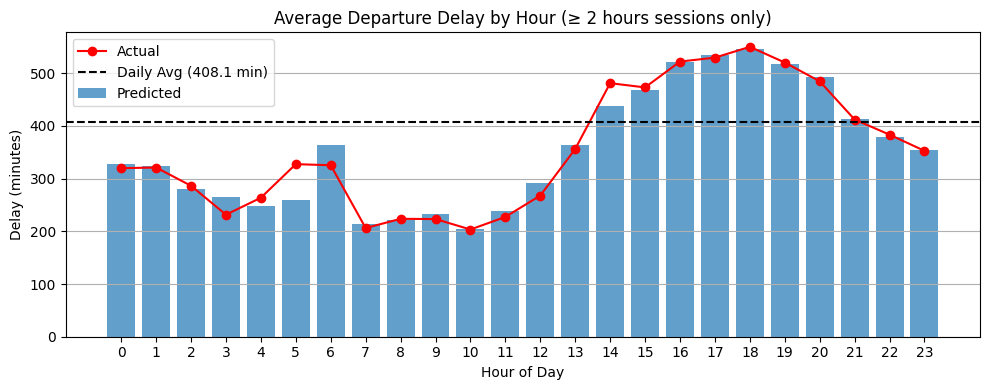

In [28]:
# Updated script with filter: only charging sessions ≥ 2 hours

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Load & preprocess
df = pd.read_csv("energydata_with_cost.csv", parse_dates=["startTime", "chargingStartTime", "endTime"])

# Remove timezone info if present
df["startTime"] = df["startTime"].dt.tz_localize(None)
df["endTime"] = df["endTime"].dt.tz_localize(None)

# Filter: only charging sessions with duration ≥ 2 hours
df["charging_duration_minutes"] = (df["endTime"] - df["startTime"]).dt.total_seconds() / 60
df = df[(df["charging_duration_minutes"] >= 120) & (df["chargedEnergyKwh"] > 0)].copy()

# Compute delay from startTime to endTime
df["departure_delay_minutes"] = df["charging_duration_minutes"]

# Time features based on startTime
df["hour"] = df["startTime"].dt.hour
df["weekday"] = df["startTime"].dt.weekday
df["is_weekend"] = (df["weekday"] >= 5).astype(int)
df["dayofyear"] = df["startTime"].dt.dayofyear
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

# Energy features
df["chargedEnergyKwh_log"] = np.log1p(df["chargedEnergyKwh"])

# Shift indicators
df["shift_start_morning"] = df["hour"].between(7, 9).astype(int)
df["shift_end_evening"] = df["hour"].between(16, 18).astype(int)
df["weekend_and_shift"] = df["shift_start_morning"] * df["is_weekend"]

# Categorical bins
df["start_hour_bin"] = pd.cut(df["hour"], bins=[0, 6, 10, 16, 21, 24],
                              labels=["Night", "Morning", "Afternoon", "Evening", "Late"], right=False)

# One-hot encoding
weekday_dummies = pd.get_dummies(df["weekday"], prefix="wd", drop_first=True)
period_dummies = pd.get_dummies(df["start_hour_bin"], prefix="period", drop_first=True)
df = pd.concat([df, weekday_dummies, period_dummies], axis=1)

# 2. Feature set
feature_cols = [
    "hour_sin", "hour_cos", "is_weekend", "chargedEnergyKwh_log", "chargedEnergyKwh",
    "shift_start_morning", "shift_end_evening", "weekend_and_shift",
    "dayofyear_sin", "dayofyear_cos"
] + list(weekday_dummies.columns) + list(period_dummies.columns)

X = df[feature_cols].values.astype("float32")
y = df["departure_delay_minutes"].values.astype("float32")

# 3. Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

model.fit(
    X_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=0
)

# 4. Evaluate
y_pred = model.predict(X_test_s).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Save predictions
df["predicted_departure_delay_minutes"] = model.predict(scaler.transform(X)).flatten()

# 5. Hourly summary
hourly = (
    df.groupby("hour")[["departure_delay_minutes", "predicted_departure_delay_minutes"]]
    .mean()
    .reset_index()
)
daily_avg = df["departure_delay_minutes"].mean()

plt.figure(figsize=(10, 4))
plt.bar(hourly["hour"], hourly["predicted_departure_delay_minutes"], label="Predicted", alpha=0.7)
plt.plot(hourly["hour"], hourly["departure_delay_minutes"], color="red", marker="o", label="Actual")
plt.axhline(daily_avg, color="black", linestyle="--", label=f"Daily Avg ({daily_avg:.1f} min)")
plt.title("Average Departure Delay by Hour (≥ 2 hours sessions only)")
plt.xlabel("Hour of Day")
plt.ylabel("Delay (minutes)")
plt.xticks(range(24))
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

daily_avg, mae, rmse, r2

# Save to CSV
hourly.to_csv("hourly_departure_prediction_2hplus.csv", index=False)


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Maak hourly averages (24 punten)
hourly_means = (
    df.groupby("hour")[["departure_delay_minutes", "predicted_departure_delay_minutes"]]
    .mean()
    .reset_index()
)

actual = hourly_means["departure_delay_minutes"].values
predicted = hourly_means["predicted_departure_delay_minutes"].values

# 2. Bereken evaluatiestatistieken
mae_hour = mean_absolute_error(actual, predicted)
rmse_hour = np.sqrt(mean_squared_error(actual, predicted))
r2_hour = r2_score(actual, predicted)

print("📊 Hourly average evaluation (WITH outliers):")
print(f"MAE  : {mae_hour:.2f} minutes")
print(f"RMSE : {rmse_hour:.2f} minutes")
print(f"R²   : {r2_hour:.3f}")



📊 Hourly average evaluation (WITH outliers):
MAE  : 12.91 minutes
RMSE : 20.81 minutes
R²   : 0.967


In [32]:
# Filter 1%-99% percentiel van echte delaywaarden
low = df["departure_delay_minutes"].quantile(0.01)
high = df["departure_delay_minutes"].quantile(0.99)
df_wo = df[(df["departure_delay_minutes"] >= low) & (df["departure_delay_minutes"] <= high)]

# Hourly average op geschoonde data
hourly_wo = (
    df_wo.groupby("hour")[["departure_delay_minutes", "predicted_departure_delay_minutes"]]
    .mean()
    .reset_index()
)

actual_wo = hourly_wo["departure_delay_minutes"].values
predicted_wo = hourly_wo["predicted_departure_delay_minutes"].values

# Statistieken zonder outliers
mae_wo = mean_absolute_error(actual_wo, predicted_wo)
rmse_wo = np.sqrt(mean_squared_error(actual_wo, predicted_wo))
r2_wo = r2_score(actual_wo, predicted_wo)

print("\n📉 Hourly average evaluation WITHOUT outliers (1st–99th percentile):")
print(f"MAE  : {mae_wo:.2f} minutes")
print(f"RMSE : {rmse_wo:.2f} minutes")
print(f"R²   : {r2_wo:.3f}")



📉 Hourly average evaluation WITHOUT outliers (1st–99th percentile):
MAE  : 25.02 minutes
RMSE : 32.13 minutes
R²   : 0.911


✅ Sessions: 23003
⚠️ Sessions with non-positive duration: 0

📊 Session duration stats (in minutes):
count    23003.000000
mean       408.123033
std        339.911160
min        120.003250
25%        186.912958
50%        321.932400
75%        551.029725
max      13657.363017
Name: total_session_duration_minutes, dtype: float64

🚌 Average session duration: 408.1 minutes
⏰ That is approximately 6.80 hours


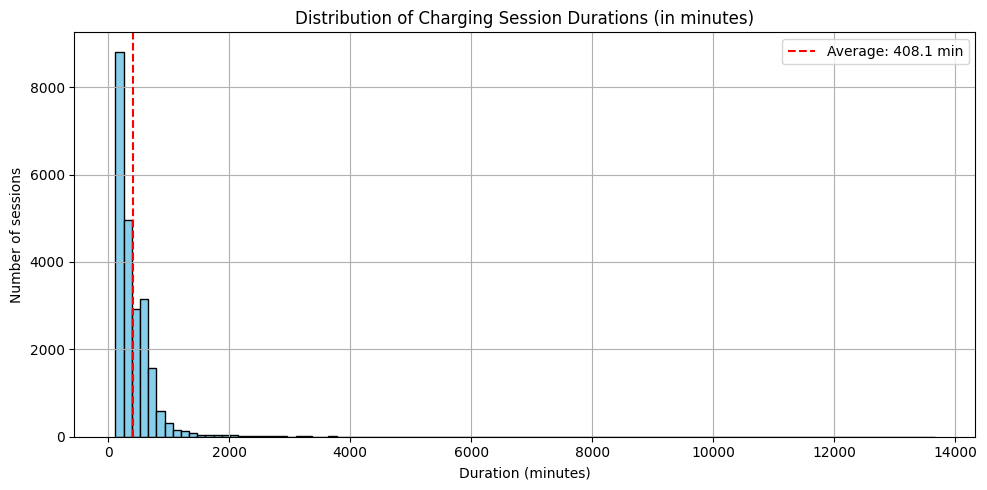

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("energydata_with_cost.csv", parse_dates=["startTime", "endTime"])

# Ensure timestamps are datetime
df["startTime"] = pd.to_datetime(df["startTime"])
df["endTime"] = pd.to_datetime(df["endTime"])

# Calculate session duration in minutes
df["total_session_duration_minutes"] = (df["endTime"] - df["startTime"]).dt.total_seconds() / 60

# Remove sessions shorter than 2 hours (120 minutes)
df = df[df["total_session_duration_minutes"] >= 120]
print(f"✅ Sessions: {len(df)}")

# Check for negative or zero durations
invalid_sessions = df[df["total_session_duration_minutes"] <= 0]
print(f"⚠️ Sessions with non-positive duration: {len(invalid_sessions)}")

# Print stats
print("\n📊 Session duration stats (in minutes):")
print(df["total_session_duration_minutes"].describe())

# Compute average
overall_avg_minutes = df["total_session_duration_minutes"].mean()
overall_avg_hours = overall_avg_minutes / 60
print(f"\n🚌 Average session duration: {overall_avg_minutes:.1f} minutes")
print(f"⏰ That is approximately {overall_avg_hours:.2f} hours")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(df["total_session_duration_minutes"], bins=100, color="skyblue", edgecolor="black")
plt.axvline(overall_avg_minutes, color='red', linestyle='--', label=f"Average: {overall_avg_minutes:.1f} min")
plt.title("Distribution of Charging Session Durations (in minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of sessions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Alphen aan den Rijn ===


/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')


Best params: {'alpha': np.float64(0.0003845401188473625), 'hidden_layer_sizes': (32,), 'learning_rate_init': np.float64(0.001934347898661638)}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Performance: MAE=3.77, RMSE=24.10, R2=0.66


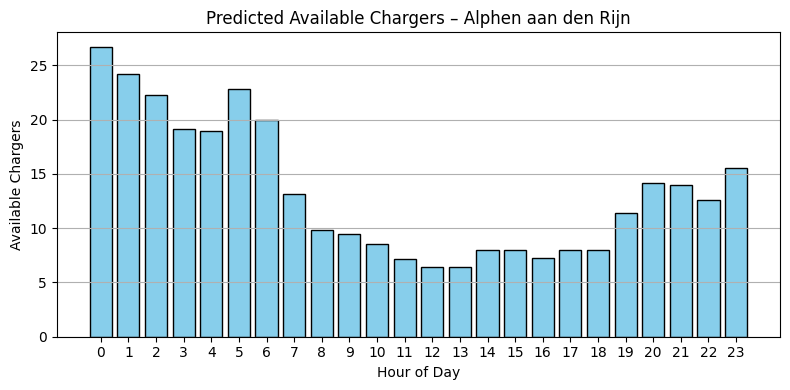

Saved CSV: Alphen_aan_den_Rijn_availability.csv

=== Katwijk ===


/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.

Best params: {'alpha': np.float64(0.0007896910002727694), 'hidden_layer_sizes': (32,), 'learning_rate_init': np.float64(0.0016601864044243652)}
Performance: MAE=2.71, RMSE=11.88, R2=0.69


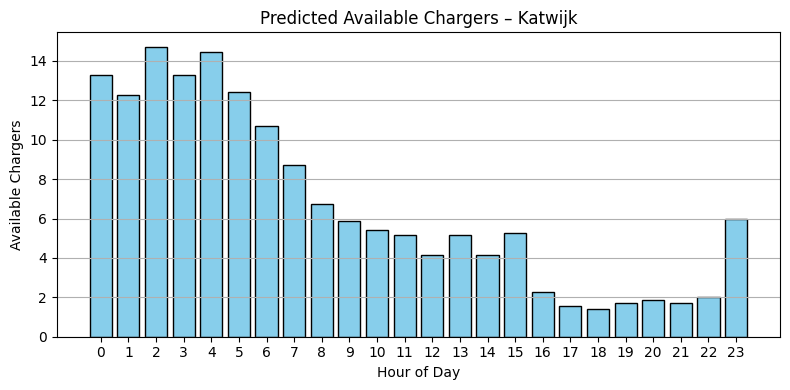

Saved CSV: Katwijk_availability.csv

=== Krimpen aan den IJssel ===


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params: {'alpha': np.float64(0.0007896910002727694), 'hidden_layer_sizes': (32,), 'learning_rate_init': np.float64(0.0016601864044243652)}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Performance: MAE=3.48, RMSE=21.73, R2=0.73


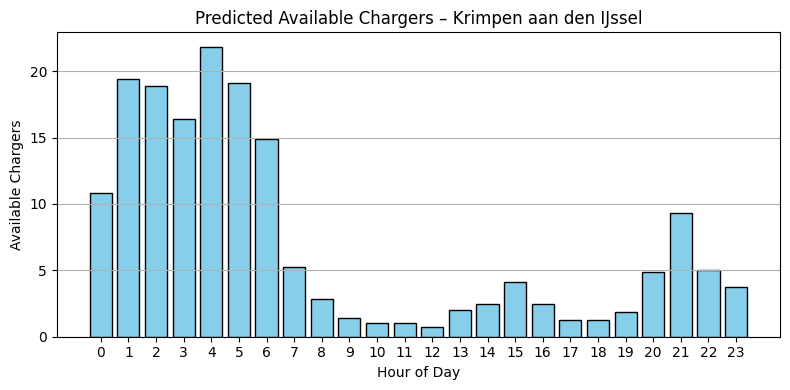

Saved CSV: Krimpen_aan_den_IJssel_availability.csv

=== Leiden ===


/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.

Best params: {'alpha': np.float64(3.058449429580245e-05), 'hidden_layer_sizes': (64,), 'learning_rate_init': np.float64(0.007319987722668248)}
Performance: MAE=1.80, RMSE=5.56, R2=0.81


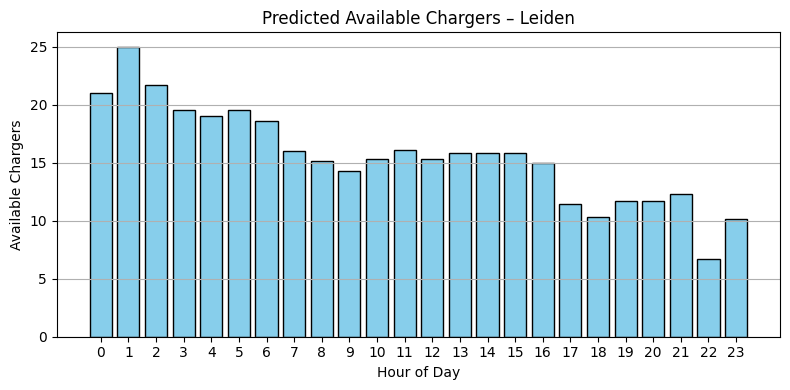

Saved CSV: Leiden_availability.csv

=== Lisse ===


/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.

Best params: {'alpha': np.float64(0.0007896910002727694), 'hidden_layer_sizes': (32,), 'learning_rate_init': np.float64(0.0016601864044243652)}
Performance: MAE=4.65, RMSE=37.97, R2=0.36


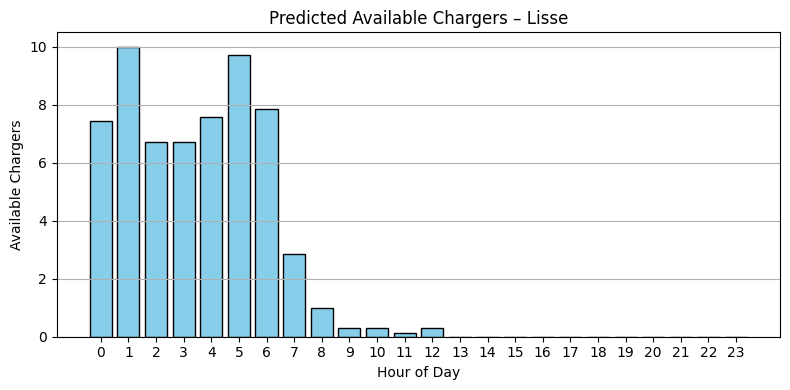

Saved CSV: Lisse_availability.csv

=== Noordwijk ===


/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/tmp/ipython-input-34-3875198004.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.

Best params: {'alpha': np.float64(0.00016599452033620266), 'hidden_layer_sizes': (64, 32), 'learning_rate_init': np.float64(0.004692488919658672)}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Performance: MAE=1.91, RMSE=7.10, R2=0.87


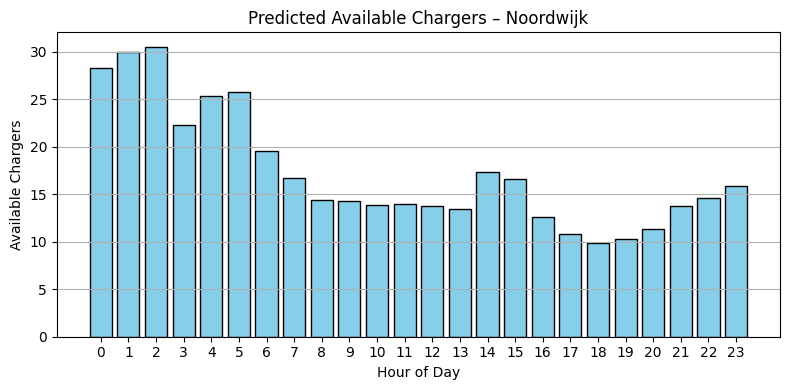

Saved CSV: Noordwijk_availability.csv

=== Summary ===
Alphen aan den Rijn: R2=0.66, MAE=3.77, RMSE=24.10
Katwijk: R2=0.69, MAE=2.71, RMSE=11.88
Krimpen aan den IJssel: R2=0.73, MAE=3.48, RMSE=21.73
Leiden: R2=0.81, MAE=1.80, RMSE=5.56
Lisse: R2=0.36, MAE=4.65, RMSE=37.97
Noordwijk: R2=0.87, MAE=1.91, RMSE=7.10


In [34]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import warnings
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
warnings.filterwarnings('ignore')

# Define each location’s CSV file and total charger count
locations = {
    "Alphen aan den Rijn":      {"file": "Alphen aan den Rijn.csv",      "total": 32},
    "Katwijk":                  {"file": "Katwijk.csv",                  "total": 24},
    "Krimpen aan den IJssel":   {"file": "Krimpen aan den IJssel.csv",   "total": 28},
    "Leiden":                   {"file": "Leiden.csv",                   "total": 30},
    "Lisse":                    {"file": "Lisse.csv",                    "total": 20},
    "Noordwijk":                {"file": "Noordwijk.csv",                "total": 36},
}

results = []

# Loop over locations
for name, info in locations.items():
    print(f"\n=== {name} ===")
    # 1) Load and preprocess
    df = pd.read_csv(info['file'])
    df['chargingStartTime'] = pd.to_datetime(df['chargingStartTime'], errors='coerce')
    df = df.dropna(subset=['chargingStartTime'])
    df['hour'] = df['chargingStartTime'].dt.hour
    df['dayofweek'] = df['chargingStartTime'].dt.dayofweek

    # 2) Compute usage and availability
    usage = df.groupby(['hour','dayofweek'])['evseName'] \
               .nunique().reset_index(name='used_chargers')
    usage['total_chargers'] = info['total']
    usage['available_chargers'] = usage['total_chargers'] - usage['used_chargers']

    # 3) Feature engineering: lagged usage
    for lag in [1,2,3]:
        usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
    # Cyclical hour encoding
    usage['hour_sin'] = np.sin(2 * np.pi * usage['hour'] / 24)
    usage['hour_cos'] = np.cos(2 * np.pi * usage['hour'] / 24)
    # One-hot weekday
    dow = pd.get_dummies(usage['dayofweek'], prefix='dow', drop_first=True)
    usage = pd.concat([usage, dow], axis=1)

    # 4) Prepare features and target
    feature_cols = ['total_chargers', 'used_lag_1', 'used_lag_2', 'used_lag_3', 'hour_sin', 'hour_cos'] + list(dow.columns)
    X = usage[feature_cols].values
    y = usage['available_chargers'].values

    # 5) Time-series CV + hyperparameter search for MLP
    tscv = TimeSeriesSplit(n_splits=3)
    param_dist = {
        'hidden_layer_sizes': [(32,), (64,), (64,32), (128,64)],
        'alpha': uniform(1e-5, 1e-3),
        'learning_rate_init': uniform(1e-4, 1e-2)
    }
    mlp = MLPRegressor(max_iter=300, random_state=42)
    search = RandomizedSearchCV(
        mlp, param_dist, n_iter=5, cv=tscv,
        scoring='r2', n_jobs=-1, random_state=42
    )
    # Scale features
    scaler = StandardScaler().fit(X)
    X_s = scaler.transform(X)
    search.fit(X_s, y)
    best = search.best_estimator_
    print(f"Best params: {search.best_params_}")

    # 6) Train best MLP & predict
    best.fit(X_s, y)
    usage['predicted_available'] = best.predict(X_s)

    # Clamp negatives and round to int
    usage['predicted_available'] = np.clip(usage['predicted_available'], 0, None)
    usage['predicted_available'] = usage['predicted_available'].round().astype(int)

    # 7) Evaluate
    mae = mean_absolute_error(y, usage['predicted_available'])
    rmse = mean_squared_error(y, usage['predicted_available'])
    r2 = r2_score(y, usage['predicted_available'])
    print(f"Performance: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")
    results.append((name, mae, rmse, r2))

    # 8) Plot inline
    avg_pred = usage.groupby('hour')['predicted_available'] \
                     .mean().reindex(range(24), fill_value=0)
    plt.figure(figsize=(8,4))
    plt.bar(avg_pred.index, avg_pred.values, color='skyblue', edgecolor='k')
    plt.title(f"Predicted Available Chargers – {name}")
    plt.xlabel('Hour of Day')
    plt.ylabel('Available Chargers')
    plt.xticks(range(24))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # 9) Save CSV
    out_csv = f"{name.replace(' ','_')}_availability.csv"
    usage[['hour','dayofweek','predicted_available']].to_csv(out_csv, index=False)
    print(f"Saved CSV: {out_csv}")

# 10) Summary
print("\n=== Summary ===")
for name, mae, rmse, r2 in results:
    print(f"{name}: R2={r2:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}")